In [1]:
pip install pandas openpyxl ccxt numpy matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.6/131.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 628.0/628.0 kB 31.8 MB/s eta 0:00:00


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving BTC_spot_ETF_data_20250709.xlsx to BTC_spot_ETF_data_20250709 (2).xlsx


In [8]:
import pandas as pd
import ccxt
import numpy as np
import traceback
import io
import time
from datetime import datetime, timedelta

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration Parameters ---
INITIAL_CAPITAL = 100000.0
POSITION_INVESTMENT_AMOUNT = INITIAL_CAPITAL * 0.25
TRANSACTION_COST_PCT = 0.001

BTC_SYMBOL = 'BTC/USDT'
EXCHANGE_NAME = 'coinbase'

Running in a Colab environment. Please upload your file.


Saving BTC_spot_ETF_data_20250721.xlsx to BTC_spot_ETF_data_20250721 (5).xlsx
User uploaded file "BTC_spot_ETF_data_20250721 (5).xlsx"

Loading data...
Fetching BTC data from coinbase starting from 2024-01-10T00:00:00.000Z...
Fetching BTC data from coinbase starting from 2024-11-05T00:00:00.000Z...

--- Starting NII Ratio MA Crossover Optimization ---
Testing with NII Ratio MA Window: 2 days
Testing with NII Ratio MA Window: 4 days
Testing with NII Ratio MA Window: 6 days
Testing with NII Ratio MA Window: 8 days
Testing with NII Ratio MA Window: 10 days
Testing with NII Ratio MA Window: 12 days
Testing with NII Ratio MA Window: 14 days
Testing with NII Ratio MA Window: 16 days
Testing with NII Ratio MA Window: 18 days
Testing with NII Ratio MA Window: 20 days
Testing with NII Ratio MA Window: 22 days
Testing with NII Ratio MA Window: 24 days
Testing with NII Ratio MA Window: 26 days
Testing with NII Ratio MA Window: 28 days
Testing with NII Ratio MA Window: 30 days


--- OPTIMIZATION C

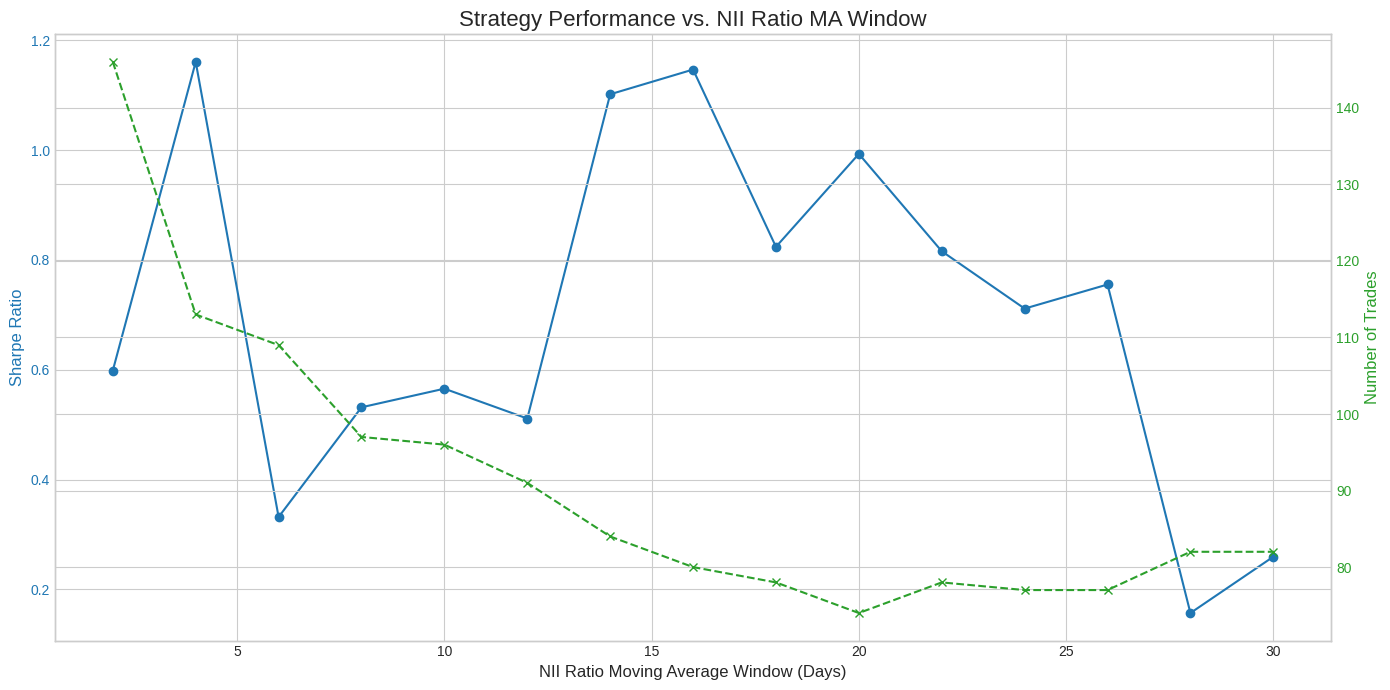

In [10]:
# --- Data Loading and Preparation Functions (no changes) ---
def load_etf_data(file_source):
    try:
        df = pd.read_excel(file_source)
        if 'Date' not in df.columns or 'NetInflow' not in df.columns:
            raise ValueError("Excel file must contain 'Date' and 'NetInflow' columns.")
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.sort_values(by='Date')
        df.set_index('Date', inplace=True)
        df = df.resample('D').sum()
        return df
    except Exception as e:
        print(f"Error loading ETF data: {e}")
        return None

def fetch_btc_price_data_full(symbol, exchange_name, start_date_str, end_date_str):
    try:
        exchange = getattr(ccxt, exchange_name)()
    except AttributeError:
        print(f"Error: Exchange '{exchange_name}' not found by ccxt.")
        return None
    if not exchange.has['fetchOHLCV']: return None
    all_ohlcv = []
    since = exchange.parse8601(start_date_str + 'T00:00:00Z')
    end_timestamp = exchange.parse8601(end_date_str + 'T23:59:59Z')
    limit = 1000
    while since < end_timestamp:
        try:
            print(f"Fetching BTC data from {exchange_name} starting from {exchange.iso8601(since)}...")
            ohlcv = exchange.fetch_ohlcv(symbol, '1d', since, limit)
            if not ohlcv: break
            ohlcv = [c for c in ohlcv if c[0] <= end_timestamp]
            if not ohlcv: break
            all_ohlcv.extend(ohlcv)
            since = ohlcv[-1][0] + 86400000
            time.sleep(exchange.rateLimit / 1000)
        except Exception as e:
            print(f"An error occurred while fetching BTC data: {e}"); traceback.print_exc(); return None
    if not all_ohlcv: return None
    df = pd.DataFrame(all_ohlcv, columns=['timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'])
    df['Date'] = pd.to_datetime(df['timestamp'], unit='ms')
    df = df.drop_duplicates(subset='timestamp').sort_values(by='Date')
    df.set_index('Date', inplace=True)
    return df[['Open', 'High', 'Low', 'Close', 'Volume']]

def align_data(etf_df, btc_df):
    if etf_df is None or btc_df is None: return None
    if etf_df.index.tz is not None: etf_df.index = etf_df.index.tz_localize(None)
    if btc_df.index.tz is not None: btc_df.index = btc_df.index.tz_localize(None)
    combined_df = pd.merge(btc_df, etf_df, left_index=True, right_index=True, how='inner')
    combined_df['NetInflow_shifted'] = combined_df['NetInflow'].shift(1)
    combined_df.dropna(subset=['NetInflow_shifted'], inplace=True)
    return combined_df

# --- NEW: Signal Generation Function based on NII Ratio MA Crossover ---
def generate_signals_nii_ma_crossover(df, ma_window_days):
    """
    Generates signals when the NII Ratio crosses its own moving average.
    - Buy Signal: NII Ratio crosses ABOVE its MA.
    - Sell Signal: NII Ratio crosses BELOW its MA.
    """
    df_signal = df.copy()

    # Calculate the NII Ratio
    df_signal['NII_Ratio'] = df_signal['NetInflow_shifted'] / (df_signal['Close'].shift(1) + 1e-9)

    # Calculate the moving average of the NII Ratio
    df_signal['NII_MA'] = df_signal['NII_Ratio'].rolling(window=ma_window_days).mean()

    df_signal.dropna(subset=['NII_Ratio', 'NII_MA'], inplace=True)

    df_signal['Signal'] = 0

    # Buy when NII crosses ABOVE its moving average
    buy_condition = (df_signal['NII_Ratio'] > df_signal['NII_MA']) & (df_signal['NII_Ratio'].shift(1) <= df_signal['NII_MA'].shift(1))
    df_signal.loc[buy_condition, 'Signal'] = 1

    # Sell when NII crosses BELOW its moving average
    sell_condition = (df_signal['NII_Ratio'] < df_signal['NII_MA']) & (df_signal['NII_Ratio'].shift(1) >= df_signal['NII_MA'].shift(1))
    df_signal.loc[sell_condition, 'Signal'] = -1

    return df_signal

# --- Backtesting and Performance Functions (Using Pyramiding Version, no changes) ---
def run_backtest_pyramiding(df, initial_capital, position_investment, transaction_cost_pct):
    cash = initial_capital
    btc_held = 0.0
    total_position_cost = 0.0
    average_entry_price = 0.0
    portfolio_values = []
    num_trades = 0
    num_wins = 0
    for i in range(len(df)):
        date = df.index[i]
        today_open = df['Open'].iloc[i]
        today_close = df['Close'].iloc[i]
        signal = df['Signal'].iloc[i]
        if signal == 1:
            if cash >= position_investment:
                buy_price = today_open
                btc_to_acquire = position_investment / buy_price
                fee = position_investment * transaction_cost_pct
                cash -= (position_investment + fee)
                btc_held += btc_to_acquire
                cost_of_this_buy = btc_to_acquire * buy_price
                total_position_cost += cost_of_this_buy
                average_entry_price = total_position_cost / btc_held
        elif btc_held > 0 and signal == -1:
            sell_price = today_open
            proceeds = btc_held * sell_price
            fee = proceeds * transaction_cost_pct
            cash += (proceeds - fee)
            num_trades += 1
            if sell_price > average_entry_price:
                num_wins += 1
            btc_held = 0.0
            total_position_cost = 0.0
            average_entry_price = 0.0
        current_portfolio_value = cash + (btc_held * today_close)
        portfolio_values.append({'Date': date, 'PortfolioValue': current_portfolio_value})
    portfolio_df = pd.DataFrame(portfolio_values).set_index('Date') if portfolio_values else None
    return {'portfolio_df': portfolio_df, 'num_trades': num_trades, 'num_wins': num_wins}

def calculate_performance_metrics(portfolio_df, initial_capital):
    if portfolio_df is None or portfolio_df.empty or len(portfolio_df) < 2:
        return {'Sharpe Ratio': 0, 'Total Return (%)': 0, 'Max Drawdown (%)': 0}
    metrics = {}
    final_value = portfolio_df['PortfolioValue'].iloc[-1]
    metrics['Total Return (%)'] = ((final_value / initial_capital) - 1) * 100
    portfolio_df['Peak'] = portfolio_df['PortfolioValue'].cummax()
    portfolio_df['Drawdown'] = (portfolio_df['PortfolioValue'] - portfolio_df['Peak']) / portfolio_df['Peak']
    metrics['Max Drawdown (%)'] = portfolio_df['Drawdown'].min() * 100
    portfolio_df['Daily Return'] = portfolio_df['PortfolioValue'].pct_change()
    avg_daily_return = portfolio_df['Daily Return'].mean()
    std_daily_return = portfolio_df['Daily Return'].std()
    if std_daily_return != 0 and not np.isnan(std_daily_return):
        metrics['Sharpe Ratio'] = (avg_daily_return / std_daily_return) * np.sqrt(252)
    else:
        metrics['Sharpe Ratio'] = 0.0
    return metrics

# --- Main Execution Block ---
if __name__ == '__main__':
    file_source = None
    try:
        from google.colab import files
        print("Running in a Colab environment. Please upload your file.")
        uploaded = files.upload()
        if uploaded:
            filename = next(iter(uploaded))
            print(f'User uploaded file "{filename}"')
            file_source = io.BytesIO(uploaded[filename])
        else:
            print("No file was uploaded."); exit()
    except (ImportError, ModuleNotFoundError):
        print("Not in Colab. This script is designed for Google Colab. Exiting."); exit()

    print("\nLoading data...")
    etf_df = load_etf_data(file_source)
    if etf_df is None: exit()

    start_date_btc = etf_df.index.min().strftime('%Y-%m-%d')
    end_date_btc = etf_df.index.max().strftime('%Y-%m-%d')

    btc_df = fetch_btc_price_data_full(BTC_SYMBOL, EXCHANGE_NAME, start_date_btc, end_date_btc)
    if btc_df is None: exit()

    base_data = align_data(etf_df, btc_df)
    if base_data is None or base_data.empty:
        print("Could not align data. Exiting."); exit()

    # --- NEW: Optimization loop for NII Ratio MA Window ---
    # Define a range of MA window lengths to test (e.g., from 1 week to 2 months)
    ma_window_options = range(2, 31, 2)
    optimization_results = []

    print("\n--- Starting NII Ratio MA Crossover Optimization ---")
    for ma_window in ma_window_options:
        print(f"Testing with NII Ratio MA Window: {ma_window} days")

        # Use the new signal generation function
        df_with_signals = generate_signals_nii_ma_crossover(base_data.copy(), ma_window_days=ma_window)

        if df_with_signals.empty: continue

        backtest_results = run_backtest_pyramiding(df_with_signals, INITIAL_CAPITAL, POSITION_INVESTMENT_AMOUNT, TRANSACTION_COST_PCT)

        portfolio_history = backtest_results['portfolio_df']
        num_trades = backtest_results['num_trades']
        num_wins = backtest_results['num_wins']

        if portfolio_history is not None and not portfolio_history.empty:
            metrics = calculate_performance_metrics(portfolio_history, INITIAL_CAPITAL)
            win_rate = (num_wins / num_trades) * 100 if num_trades > 0 else 0
            result_entry = {
                'MA Window': ma_window,
                'Sharpe Ratio': metrics['Sharpe Ratio'], 'Total Return (%)': metrics['Total Return (%)'],
                'Max Drawdown (%)': metrics['Max Drawdown (%)'], 'Num Trades': num_trades, 'Win Rate (%)': win_rate
            }
            optimization_results.append(result_entry)

    if optimization_results:
        results_df = pd.DataFrame(optimization_results)
        print("\n\n--- OPTIMIZATION COMPLETE ---")
        results_df_sorted = results_df.sort_values(by='Sharpe Ratio', ascending=False)

        # Format for better readability
        results_df_sorted['Win Rate (%)'] = results_df_sorted['Win Rate (%)'].map('{:.1f}'.format)
        print(results_df_sorted.to_string(index=False))

        best_params_row = results_df_sorted.iloc[0]

        print(f"\n\n--- Best Strategy Found ---")
        print(f"Optimal NII Ratio MA Window: {int(best_params_row['MA Window'])} days")
        print(f"Sharpe Ratio: {float(best_params_row['Sharpe Ratio']):.2f}")
        print(f"Total Return: {float(best_params_row['Total Return (%)']):.2f}%")
        print(f"Number of Trades: {int(best_params_row['Num Trades'])}")

        # --- Visualization for Single-Parameter Optimization ---
        print("\n--- Generating Optimization Performance Chart ---")

        plt.style.use('seaborn-v0_8-whitegrid')
        fig, ax1 = plt.subplots(figsize=(14, 7))

        # Plot Sharpe Ratio on the left Y-axis
        color = 'tab:blue'
        ax1.set_xlabel('NII Ratio Moving Average Window (Days)', fontsize=12)
        ax1.set_ylabel('Sharpe Ratio', color=color, fontsize=12)
        ax1.plot(results_df['MA Window'], results_df['Sharpe Ratio'], color=color, marker='o', linestyle='-', label='Sharpe Ratio')
        ax1.tick_params(axis='y', labelcolor=color)

        # Create a second Y-axis for the number of trades
        ax2 = ax1.twinx()
        color = 'tab:green'
        ax2.set_ylabel('Number of Trades', color=color, fontsize=12)
        ax2.plot(results_df['MA Window'], results_df['Num Trades'], color=color, marker='x', linestyle='--', label='Number of Trades')
        ax2.tick_params(axis='y', labelcolor=color)

        plt.title('Strategy Performance vs. NII Ratio MA Window', fontsize=16)
        fig.tight_layout()
        plt.show()

    else:
        print("\nOptimization did not yield any results.")

Running in a Colab environment. Please upload your file.


Saving BTC_spot_ETF_data_20250721.xlsx to BTC_spot_ETF_data_20250721 (2).xlsx
User uploaded file "BTC_spot_ETF_data_20250721 (2).xlsx"

Loading data...
Fetching BTC data from coinbase starting from 2024-01-10T00:00:00.000Z...
Fetching BTC data from coinbase starting from 2024-11-05T00:00:00.000Z...

--- Preparing data for plotting ---

--- Generating NII Ratio vs. BTC Price Chart ---


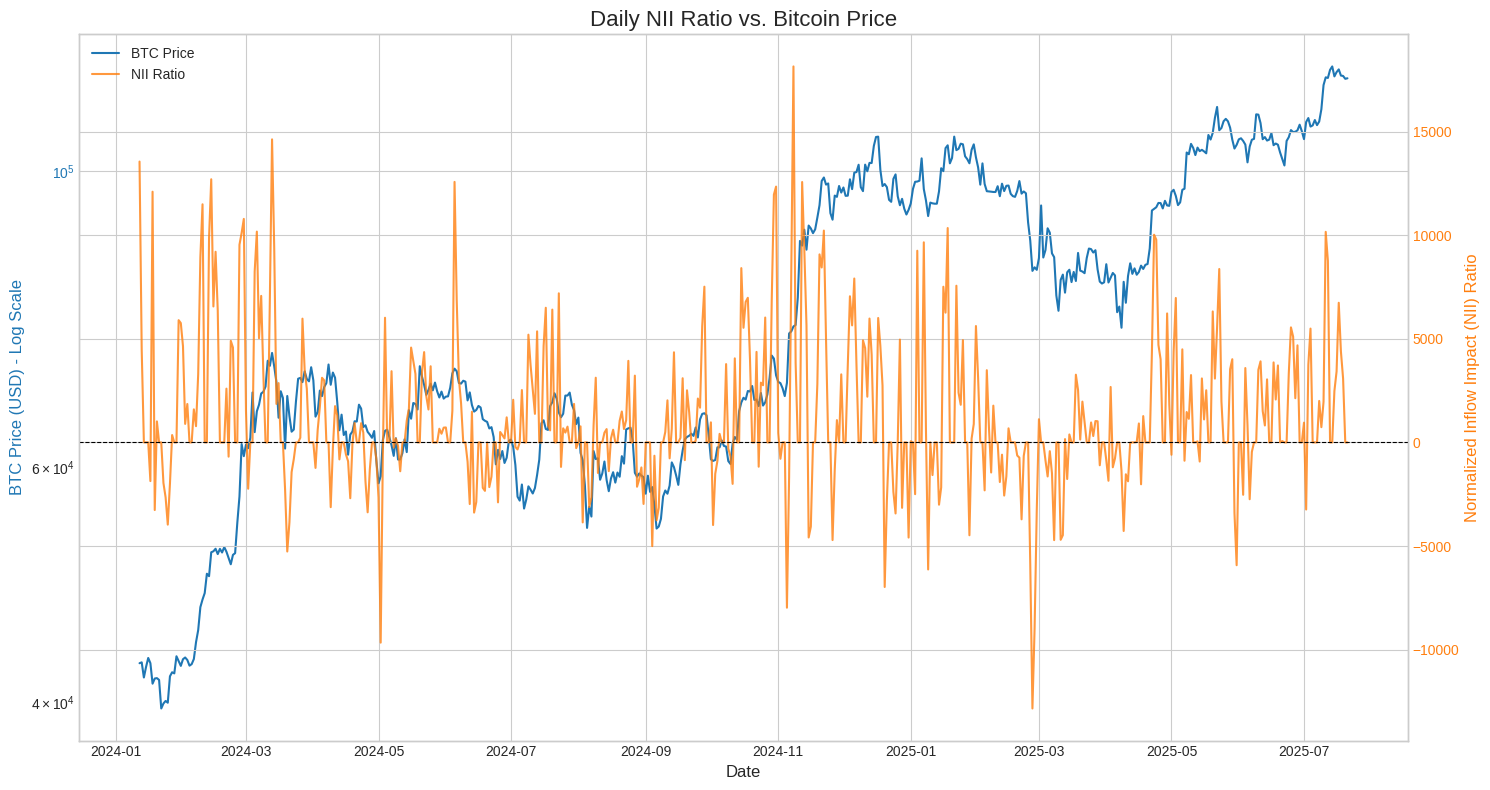

In [6]:
import pandas as pd
import ccxt
import numpy as np
import traceback
import io
import time
from datetime import datetime, timedelta

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration Parameters ---
BTC_SYMBOL = 'BTC/USDT'
EXCHANGE_NAME = 'coinbase'

# --- Data Loading and Preparation Functions ---
def load_etf_data(file_source):
    """Loads and prepares the ETF inflow data from the uploaded Excel file."""
    try:
        df = pd.read_excel(file_source)
        if 'Date' not in df.columns or 'NetInflow' not in df.columns:
            raise ValueError("Excel file must contain 'Date' and 'NetInflow' columns.")
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.sort_values(by='Date')
        df.set_index('Date', inplace=True)
        # Resample to daily frequency, summing up inflows for any given day
        df = df.resample('D').sum()
        return df
    except Exception as e:
        print(f"Error loading ETF data: {e}")
        return None

def fetch_btc_price_data_full(symbol, exchange_name, start_date_str, end_date_str):
    """Fetches daily OHLCV data for Bitcoin from the specified exchange."""
    try:
        exchange = getattr(ccxt, exchange_name)()
    except AttributeError:
        print(f"Error: Exchange '{exchange_name}' not found by ccxt.")
        return None

    if not exchange.has['fetchOHLCV']: return None
    all_ohlcv = []
    since = exchange.parse8601(start_date_str + 'T00:00:00Z')
    end_timestamp = exchange.parse8601(end_date_str + 'T23:59:59Z')
    limit = 1000
    while since < end_timestamp:
        try:
            print(f"Fetching BTC data from {exchange_name} starting from {exchange.iso8601(since)}...")
            ohlcv = exchange.fetch_ohlcv(symbol, '1d', since, limit)
            if not ohlcv: break
            ohlcv = [c for c in ohlcv if c[0] <= end_timestamp]
            if not ohlcv: break
            all_ohlcv.extend(ohlcv)
            since = ohlcv[-1][0] + 86400000
            time.sleep(exchange.rateLimit / 1000)
        except Exception as e:
            print(f"An error occurred while fetching BTC data: {e}"); traceback.print_exc(); return None
    if not all_ohlcv: return None
    df = pd.DataFrame(all_ohlcv, columns=['timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'])
    df['Date'] = pd.to_datetime(df['timestamp'], unit='ms')
    df = df.drop_duplicates(subset='timestamp').sort_values(by='Date')
    df.set_index('Date', inplace=True)
    return df[['Open', 'High', 'Low', 'Close', 'Volume']]

def align_data(etf_df, btc_df):
    """Aligns the ETF and BTC dataframes on their date index."""
    if etf_df is None or btc_df is None: return None
    if etf_df.index.tz is not None: etf_df.index = etf_df.index.tz_localize(None)
    if btc_df.index.tz is not None: btc_df.index = btc_df.index.tz_localize(None)
    combined_df = pd.merge(btc_df, etf_df, left_index=True, right_index=True, how='inner')
    # Shift the inflow data by one day to prevent lookahead bias
    combined_df['NetInflow_shifted'] = combined_df['NetInflow'].shift(1)
    combined_df.dropna(subset=['NetInflow_shifted'], inplace=True)
    return combined_df

# --- Main Execution Block ---
if __name__ == '__main__':
    file_source = None
    try:
        from google.colab import files
        print("Running in a Colab environment. Please upload your file.")
        uploaded = files.upload()
        if uploaded:
            filename = next(iter(uploaded))
            print(f'User uploaded file "{filename}"')
            file_source = io.BytesIO(uploaded[filename])
        else:
            print("No file was uploaded."); exit()
    except (ImportError, ModuleNotFoundError):
        print("Not in Colab. This script is designed for Google Colab. Exiting."); exit()

    print("\nLoading data...")
    etf_df = load_etf_data(file_source)
    if etf_df is None: exit()

    start_date_btc = etf_df.index.min().strftime('%Y-%m-%d')
    end_date_btc = etf_df.index.max().strftime('%Y-%m-%d')

    btc_df = fetch_btc_price_data_full(BTC_SYMBOL, EXCHANGE_NAME, start_date_btc, end_date_btc)
    if btc_df is None: exit()

    base_data = align_data(etf_df, btc_df)
    if base_data is None or base_data.empty:
        print("Could not align data. Exiting."); exit()

    # --- Prepare Data for Plotting ---
    print("\n--- Preparing data for plotting ---")
    plot_df = base_data.copy()

    # Calculate the NII Ratio using the closing price as a proxy for market cap
    # We use yesterday's inflow and yesterday's price to determine today's ratio
    plot_df['NII_Ratio'] = plot_df['NetInflow_shifted'] / (plot_df['Close'].shift(1) + 1e-9)

    # Drop any rows with missing values that were created by the shifting
    plot_df.dropna(subset=['NII_Ratio'], inplace=True)

    if plot_df.empty:
        print("Not enough data to create a plot after calculations.")
    else:
        # --- Generate the Chart ---
        print("\n--- Generating NII Ratio vs. BTC Price Chart ---")

        # Use a nice style for the plot
        plt.style.use('seaborn-v0_8-whitegrid')

        # Create the figure and the first Y-axis (for BTC price)
        fig, ax1 = plt.subplots(figsize=(15, 8))

        # Plot BTC Price on the left Y-axis (ax1)
        color1 = 'tab:blue'
        ax1.set_xlabel('Date', fontsize=12)
        ax1.set_ylabel('BTC Price (USD) - Log Scale', color=color1, fontsize=12)
        ax1.plot(plot_df.index, plot_df['Close'], color=color1, label='BTC Price')
        ax1.tick_params(axis='y', labelcolor=color1)
        # Using a logarithmic scale for price makes long-term trends easier to see
        ax1.set_yscale('log')

        # Create the second Y-axis (for NII Ratio) that shares the same X-axis
        ax2 = ax1.twinx()

        # Plot NII Ratio on the right Y-axis (ax2)
        color2 = 'tab:orange'
        ax2.set_ylabel('Normalized Inflow Impact (NII) Ratio', color=color2, fontsize=12)
        ax2.plot(plot_df.index, plot_df['NII_Ratio'], color=color2, label='NII Ratio', alpha=0.8, linewidth=1.5)
        ax2.tick_params(axis='y', labelcolor=color2)
        # Add a horizontal line at zero to easily distinguish between net inflows and outflows
        ax2.axhline(0, color='black', linestyle='--', linewidth=0.8)

        # Final Touches
        plt.title('Daily NII Ratio vs. Bitcoin Price', fontsize=16)
        fig.tight_layout()  # Adjust plot to prevent labels from overlapping

        # Create a single legend for both lines
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc='upper left')

        plt.show()